#### Анализ проблемы (что за задача решается, почему она важна)

В рамках проекта мне было интересно попробовать определять категории писем на спам - не спам, основываясь на содержании сообщений.

Данная задача остается актуальной и на сегодняшний день, потому что в эпоху интернета людям на почту могут приходить письма-паразиты, на которые не хочется уделять никакого внимания. С этим может помочь создание модели, которая автоматически будет определять куда положить письмо в вашей почте. Это ли не прекрасно?

Изучив проблематику проблемы со спамом оказывается, что ежедневно через Интернет отправляется около 20 миллиардов электронных писем с категорией не спам, а это только 15% от общего количества электронных писем. Все отальные электронные письма являются спамом, то есть ежедневно рассылается более 120 миллиардов спам-сообщений.

Приступим к задаче

#### EDA датасета (дисбаланс, метрики, особенности)

Подобрав датасет из kaggle.com, я убедился в том, что он состоит из 5572 сообщений.

In [17]:
import pandas as pd

raw = pd.read_csv("messages.csv")
print(raw.head())
print(raw.shape)

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)


Удалив дубликаты, оказалось, что дальше мы будем работать с 5157 сообщениями, что довольно много для определения спама

In [18]:
data = raw.drop_duplicates(subset = ["Message"])
print(data.head())
print(data.shape)

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
(5157, 2)


Также нам стоит замениь категории на числовые эквиваленты, чтобы качественнее работать с моделями  
1 - спам  
0 - не спам

In [19]:
data["Category"] = data["Category"].apply(lambda x: 1 if x == "spam" else 0)
data.head()

<ipython-input-5-91f965c93ebe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Category"] = data["Category"].apply(lambda x: 1 if x == "spam" else 0)


,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


После построения графиков оказалось, что 12% сообщений помечены как спам, а остальные 88% — как не спам. 

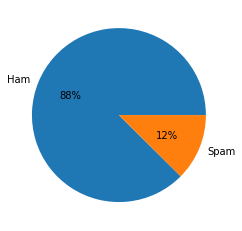

In [20]:
import matplotlib.pyplot as plt

counts = data["Category"].value_counts(normalize=True)
plt.pie(counts, labels=['Ham', 'Spam'], autopct='%1.0f%%');

Если говорить о количестве, то мы имеем чуть меньше тысячи сообщений со спамом и чуть больше 4000 сообщений без спама.

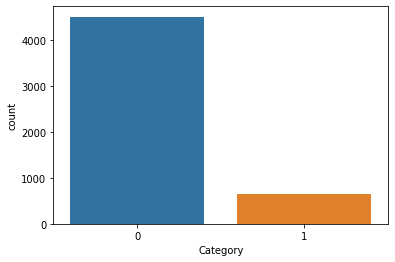

In [21]:
import seaborn as sns

sns.countplot(x="Category", data = data);

#### Сделали модель ML с использованием предобученных или обученных эмбеддингов

Для начала токенизируем слова в сообщениях, чтобы получить целочисленные векторы, где каждое целое число является индексом токена в словаре.

In [22]:
import nltk
import re
import string

from nltk.corpus import stopwords

nltk.download('stopwords')

# Очистка данных с последующей токенизацией слов
def clean_text(text):
    to_lower_text = text.lower()
    to_remove_punctuation = "".join([char for char in to_lower_text if char not in string.punctuation])
    to_remove_stopwords = [word for word in to_remove_punctuation.split() if word not in stopwords.words('english')]

    return to_remove_stopwords

clean_text(data["Message"][0])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amore',
 'wat']

Применяем TF-IDF embedding для сообщений

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

message = TfidfVectorizer(analyzer = clean_text).fit_transform(data['Message'])

Разделяем набор данных на обучающую и тестовую выборки в соотношении 80/20

In [24]:
from sklearn.model_selection import train_test_split

X = message
y = data["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Определяем загрузчик данных для обучения

Воспользуемся моделью KNN 

In [25]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = [3, 5, 10, 15]
y_pred_train = []
y_pred_tests = []

for n in neighbors:
    knn_model = KNeighborsClassifier(n_neighbors = n)
    knn_model.fit(X_train, y_train)

    y_pred_train.append(knn_model.predict(X_train))
    y_pred_tests.append(knn_model.predict(X_test))

Оценим данные и воспользуемся метриками

In [26]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

Поскольку мы работаем с несбалансированным набором данных accuracy_score не является качественной мерой оценки данных, поскольку она не различает количество правильно классифицированных примеров разных классов.  
При анализе результатов стоит внимание уделять f1_score, она более точная в плане оценки данных

In [27]:
print("\nTrain data\n")
for i in range(len(y_pred_train)):
    print(f"accuracy_score for {neighbors[i]} neighbors = {accuracy_score(y_train, y_pred_train[i])}")
    print(f"f1_score for {neighbors[i]} neighbors       = {f1_score(y_train, y_pred_train[i],  average='macro')}")
    print()
    
print("\nTest data\n")
for i in range(len(y_pred_tests)):
    print(f"accuracy_score for {neighbors[i]} neighbors = {accuracy_score(y_test, y_pred_tests[i])}")
    print(f"f1_score for {neighbors[i]} neighbors       = {f1_score(y_test, y_pred_tests[i], average='macro')}")
    print()


Train data

accuracy_score for 3 neighbors = 0.9343030303030303
f1_score for 3 neighbors       = 0.7986039059717376

accuracy_score for 5 neighbors = 0.9132121212121213
f1_score for 5 neighbors       = 0.7019012914279993

accuracy_score for 10 neighbors = 0.8870303030303031
f1_score for 10 neighbors       = 0.5414549968702769

accuracy_score for 15 neighbors = 0.9323636363636364
f1_score for 15 neighbors       = 0.791128285663002


Test data

accuracy_score for 3 neighbors = 0.9127906976744186
f1_score for 3 neighbors       = 0.728836519484766

accuracy_score for 5 neighbors = 0.8992248062015504
f1_score for 5 neighbors       = 0.6630500301386377

accuracy_score for 10 neighbors = 0.874031007751938
f1_score for 10 neighbors       = 0.5084345825211414

accuracy_score for 15 neighbors = 0.9215116279069767
f1_score for 15 neighbors       = 0.7685092619003442



Модель работает неплохо, если вести дальше эксперимент на соседях > 15, возможно результат дойдет и до 80%.  
Если судить матрицу ошибок, то почти во всех случаях количество сообщеий, которые определены как спам, хотя такими не являются - крайне мал.  
Например, на 15 соседях на тестовой выборке мы имеем лишь 1 ошибку среди 901 сообщения. Я этим доволен.  
Однако модель плохо понимает когда перед ней спам, поэтому чаще относит спам к не спаму, этим я не доволен. Попробуем воспользоваться нейронкой и получить результат получше


Train data

confusion_matrix for 3 neighbors


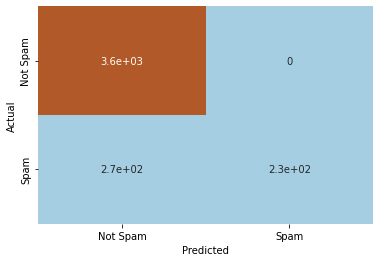


confusion_matrix for 5 neighbors


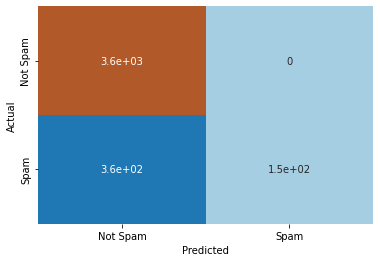


confusion_matrix for 10 neighbors


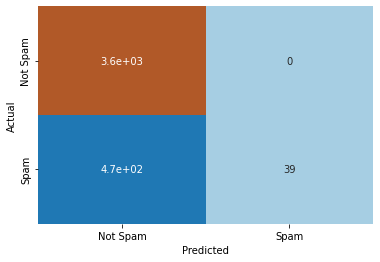


confusion_matrix for 15 neighbors


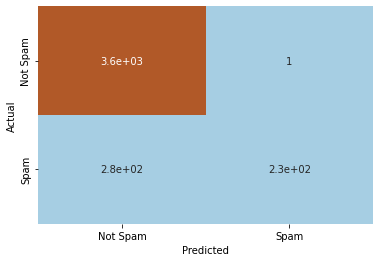



Test data

confusion_matrix for 3 neighbors


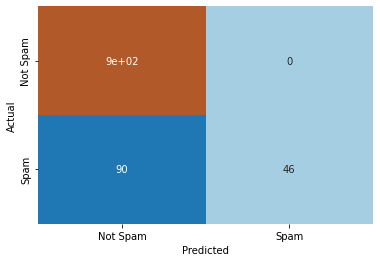


confusion_matrix for 5 neighbors


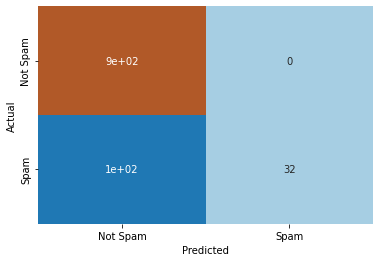


confusion_matrix for 10 neighbors


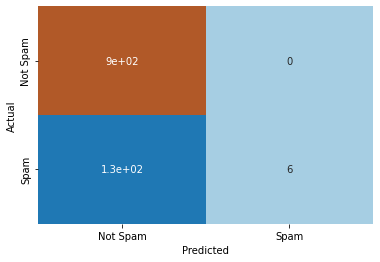


confusion_matrix for 15 neighbors


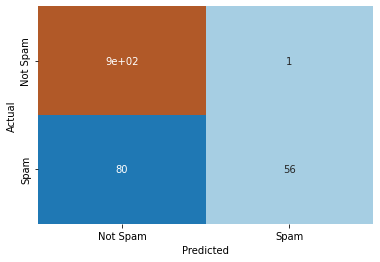

In [28]:
print("\nTrain data\n")
for i in range(len(y_pred_train)):
    print(f"confusion_matrix for {neighbors[i]} neighbors")
    confusion_matrix = pd.crosstab(y_train, y_pred_train[i], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot = True, cmap = 'Paired', cbar = False, xticklabels=['Not Spam', 'Spam'],  yticklabels=['Not Spam', 'Spam'])
    plt.show()
    print()
    
print("\nTest data\n")
for i in range(len(y_pred_train)):
    print(f"confusion_matrix for {neighbors[i]} neighbors")
    confusion_matrix = pd.crosstab(y_test, y_pred_tests[i], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot = True, cmap = 'Paired', cbar = False, xticklabels=['Not Spam', 'Spam'],  yticklabels=['Not Spam', 'Spam'])
    plt.show()
    print()

#### Использовали deep learning модель (RNN и/или CNN)

In [29]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2023-12-26 17:02:22.365390: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-26 17:02:23.859058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 17:02:27.673149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Воспользуемся следующей RNN моделью

In [30]:
class RNNModel:
    def __init__(self):
        self.regressor = Sequential()

    def build_model(self, input_shape):
        # Добавление первого слоя LSTM с некоторой регуляризацией Dropout
        self.regressor.add(LSTM(units = 30, return_sequences = True, input_shape = input_shape))
        # Dropout применяется для предотвращения переобучения путем случайного обнуления нейронов во время обучения.
        self.regressor.add(Dropout(0.2))

       # Добавление второго слоя LSTM с регуляризацией Dropout
        self.regressor.add(LSTM(units = 30, return_sequences = True))
        self.regressor.add(Dropout(0.2))

        # Финальный слой LSTM без return_sequences
        self.regressor.add(LSTM(units = 30))
        self.regressor.add(Dropout(0.2))

        # Добавление выходного слоя, имеющий 1 нейрон - это будет выход регрессии.
        self.regressor.add(Dense(units = 1))

        # Компиляция RNN модели
        self.regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ["accuracy"])

    def train_model(self, X_train, y_train, epochs, batch_size):
        self.regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

In [31]:
# Создание и построение RNN модели
lstm_model = RNNModel()
input_shape = (X_train.shape[1], 1)
lstm_model.build_model(input_shape)

2023-12-26 17:02:36.414978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-26 17:02:36.985924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-26 17:02:36.988111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-26 17:02:36.990614: I tensorflow/core/com

In [32]:
# Обучение модели
lstm_model.train_model(X_train.toarray(), y_train, epochs = 5, batch_size = 64)

Epoch 1/5


2023-12-26 17:02:38.707125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-26 17:02:38.709893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-26 17:02:38.712158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 1572s 24s/step - loss: 0.1088 - accuracy: 0.8776
Epoch 2/5
65/65 [==============================] - 1570s 24s/step - loss: 0.1080 - accuracy: 0.8776
Epoch 3/5
65/65 [==============================] - 1576s 24s/step - loss: 0.1081 - accuracy: 0.8776
Epoch 4/5
65/65 [==============================] - 1574s 24s/step - loss: 0.1078 - accuracy: 0.8776
Epoch 5/5
65/65 [==============================] - 1556s 24s/step - loss: 0.1078 - accuracy: 0.8776


Подытожить можно тем, что модель показала 87%, при этом функция ошибки хоть и немного, но уменьшалась на каждой из эпох.  
И в итоге составила 0.1078, что является лучшим результатом из имеющихся.  
Спасибо за внимание!